# Libreria

In [25]:
# Librerias

from pathlib import Path
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow.keras.models import Model
from keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import LambdaCallback #Para parar el sobreentrenamiento

from tensorflow.keras.models import load_model

#Constantes

DATADIR = Path("../data/raw/train")

# Carga de Datos

Total files: 25000
Cat files: 12500




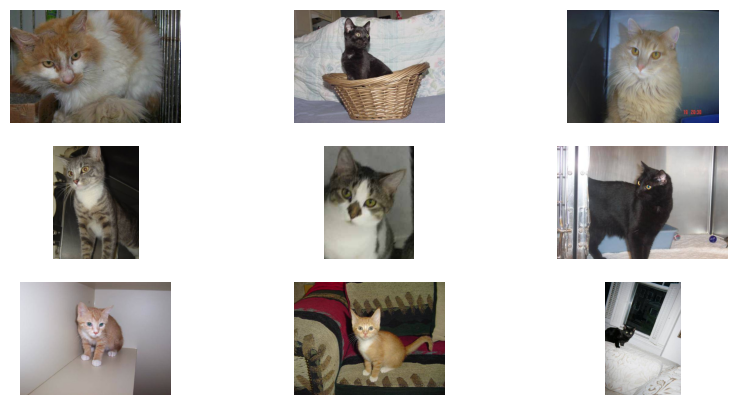

Total files: 25000
Dog files: 12500




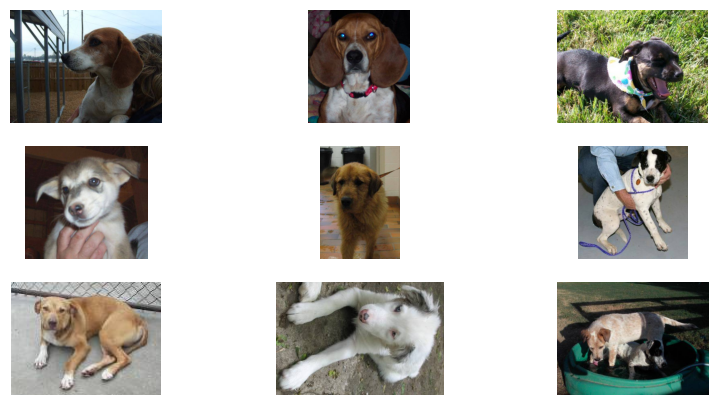

In [13]:
# Cargamos las imagenes de perro.

def LoadIMG(pet):
    totalimgs = len(list(DATADIR.glob("*.jpg")))
    petImgLst = [img.name for img in DATADIR.glob(f"{pet}*.jpg") if pet in img.stem]
    
    print(f"Total files: {totalimgs}")
    print(f"{pet.capitalize()} files: {len(petImgLst)}\n==========\n\n")
    
    pet_img = []
    
    for i in range(9):
        imgPath = DATADIR / petImgLst[i]
        img = image.load_img(imgPath)
        imgArray = image.img_to_array(img)
        imgArray /= 255.0
        pet_img.append(imgArray)
        
    plt.figure(figsize=(10,5))
    
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(pet_img[i])
        plt.axis("off")
    
    plt.show()
    
LoadIMG("cat")
LoadIMG("dog")

In [14]:
def DataGen(pet="dog"):
    imgSize = (200,200)

    imgGenTrain = ImageDataGenerator(validation_split= 0.2) #Si no ponemos el validation split se usara todo el dataframe como train y no aprenderá nada.

    #Creamos un DataFrame con la etiqueta de las imagenes.

    imgLst = os.listdir(DATADIR)

    labelData = pd.DataFrame({"file" : imgLst, "label" : [pet if pet in file else "cat" for file in imgLst]})
    
    #Generamos la data final

    dataGenTrain = imgGenTrain.flow_from_dataframe(dataframe = labelData, directory = DATADIR, x_col="file", y_col="label", target_size = imgSize, batch_size = 32, class_mode = "binary", subset="training", seed=42, shuffle=True)
    dataGenTest = imgGenTrain.flow_from_dataframe(dataframe = labelData, directory = DATADIR, x_col="file", y_col="label", target_size = imgSize, batch_size = 32, class_mode = "binary", subset="validation", seed=42, shuffle=False)
    
    return dataGenTrain, dataGenTest

dataTrain , dataTest = DataGen()

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


# MACHINE LEARNING

- Creación del Modelo

In [15]:
def ModelMaker():
    #Cargamos VGG16.

    pretrain_model = VGG16(weights="imagenet", include_top=False, input_shape=(200,200,3))

    #Capas densas
    denses = pretrain_model.output
    denses = Flatten()(denses)
    denses = Dense(units=4096, activation="relu")(denses)
    denses = Dense(units=1, activation="sigmoid")(denses)

    model = Model(inputs=pretrain_model.input, outputs=denses)

    #Hacemos un freeze al modelo preentrenado para que no entrene.
    for l in pretrain_model.layers:
        l.trainable = False

    #Compilamos el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #Guardamos el modelo
    model.save('../models/rnn-vgg16.keras')

    return model

model = ModelMaker()

- Entrenamiento del modelo

In [16]:
def TrainModel(model, imgTrain, imgTest):

    checkpoint = ModelCheckpoint("../models/best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")
    earlyStop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    #Parar si sobreentrena.
    stopOverfitting = LambdaCallback(on_epoch_end=lambda epoch, logs: model.stop_training if logs.get("val_loss") > 1.0 else None)

    hist = model.fit(imgTrain, validation_data = imgTest, epochs = 10, callbacks=[checkpoint, earlyStop, stopOverfitting])

    # Guardamos el modelo final
    model.save("../models/rnn-vgg16-e10.keras")

TrainModel(model, dataTrain, dataTest)

Epoch 1/10


/var/data/python/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 1726s 3s/step - accuracy: 0.9256 - loss: 10.2200 - val_accuracy: 0.9664 - val_loss: 0.0853
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1567s 3s/step - accuracy: 0.9828 - loss: 0.0532 - val_accuracy: 0.9702 - val_loss: 0.1081
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1565s 3s/step - accuracy: 0.9916 - loss: 0.0265 - val_accuracy: 0.9614 - val_loss: 0.2307
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1562s 3s/step - accuracy: 0.9838 - loss: 0.1052 - val_accuracy: 0.9660 - val_loss: 0.2905
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1557s 2s/step - accuracy: 0.9877 - loss: 0.0718 - val_accuracy: 0.9662 - val_loss: 0.2538
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1564s 3s/step - accuracy: 0.9935 - loss: 0.0417 - val_accuracy: 0.9682 - val_loss: 0.4040


In [21]:
#Vamos a comprobar si best_model y el final

def Challengemodels(test):

    #Cargamos los modelos
    best_model = load_model("../models/best_model.keras")
    final_model = load_model("../models/rnn-vgg16-e10.keras")

    #Cargamos las metricas.
    bestAccu, bestLoss = best_model.evaluate(test)
    finalAccu, finalLoss = final_model.evaluate(test)

    print(f"\n==========\nBest Model Accuracy: {bestAccu}\nFinal Model Accuracy: {finalAccu}\n==========\n")

    if bestAccu > finalAccu:
        return best_model
    else:
        return final_model

model = Challengemodels(dataTest)

157/157 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.9714 - loss: 0.1055
157/157 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.9638 - loss: 0.0817

Best Model Accuracy: 0.10810616612434387
Final Model Accuracy: 0.08531300723552704



- Predecimos imagen

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
cat


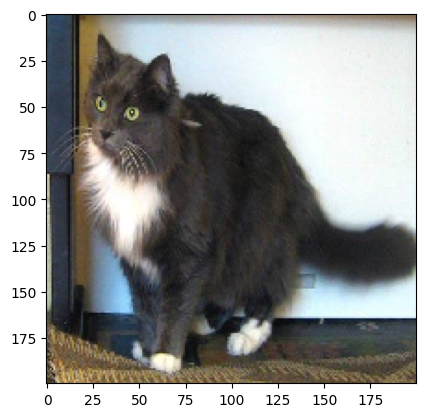

In [29]:
img = image.load_img("../data/raw/test1/9.jpg", target_size = (200, 200))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis = 0)

output = model.predict(img)

if output[0][0] > 0.5:
    print("dog")
else:
    print("cat")